In [10]:
import torch 
import torchvision
import torch.nn as nn

import numpy as np
import math
import torchvision.transforms as transforms
from dataset_wrapper import get_pet_datasets
import matplotlib.pyplot as plt

In [11]:
class configConvNet(nn.Module):
    residual = False;
    def __init__(self, in_channels=3, base_channels=16, kernel_size=2, batch_normal=True, num_classes=4, num_layers=3, activation="RELU", residuals=False):
        super(configConvNet, self).__init__()
        input_channels = in_channels;
        layer = []
        self.residual = residuals;
        out_channels = 128;
        for i in range(num_layers):
            out_channels = base_channels * (2 ** i)
            layer.append(nn.Conv2d(input_channels, out_channels, kernel_size=5, stride=1, padding=2))
            if batch_normal:
                layer.append(nn.BatchNorm2d(out_channels))
            if activation.upper() == "RELU":
                layer.append(nn.ReLU())
            elif activation.upper() == "LEAKYRELU":
                layer.append(nn.LeakyReLU(0.1))
            elif activation.upper() == "GELU":
                layer.append(nn.GELU())
            layer.append(nn.MaxPool2d(kernel_size=2, stride=2))
            input_channels = out_channels
        if self.residual:
            self.downsample = None
            if in_channels != out_channels:
                print(f"in_channels:{in_channels}, out_channels:{out_channels}")
                self.downsample = nn.Sequential(
                    nn.Conv2d(
                        in_channels, 
                        out_channels, 
                        kernel_size=1, 
                        padding='same', 
                        bias=False
                    ),
                    nn.BatchNorm2d(out_channels) if batch_normal else nn.Identity(),
                    nn.MaxPool2d(kernel_size=2, stride=(2 ** num_layers)),
                )
            
        self.features = nn.Sequential(*layer)
        sqrt = 128 // (2 ** num_layers) #this isn't what a square root is.
        print(sqrt)
        self.fc = nn.Linear(out_channels*sqrt*sqrt, num_classes)

    def forward(self, x):
        identity = x
        out = self.features(x)
        
        if self.residual:
            identity = self.downsample(identity) if self.downsample else identity
            #print("identity shape:", identity.shape, "out shape", out.shape)
            out += identity 
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

In [12]:
# Plot training loss
def generate_charts(num_layers, activation, batch_norm, residuals, train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label=f'Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss Curve \n({num_layers} layers, {activation}, batchnorm={batch_norm}, residuals={residuals})')
    plt.legend()
    
    # Plot validation accuracy
    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label=f'Validation Accuracy', color='green')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Validation Accuracy Curve \n({num_layers} layers, {activation}, batchnorm={batch_norm}, residuals={residuals})')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig(f'layers{num_layers}_batch{batch_norm}_residuals{residuals}_{activation}.png')
    plt.show()

In [13]:
def append_text_to_file(file_path, text_to_append):
    try:
        with open(file_path, 'a') as file:
            file.write(text_to_append + '\n')
        print(f"Text appended to {file_path} successfully.")
    except Exception as e:
        print(f"Error: {e}")

In [18]:
import re
import os
#i used this to 'save' my progress - in case something interrupted training
#so i wouldn't have to start at model 1 out of 48 or figure out where i left off each time
def extract_models_from_file(filepath):
    models_ive_trained = []

    #creates file if it doesn't exist
    if not os.path.exists(filepath):
        with open(filepath, "w") as file:
            pass  

    # Read file
    with open(filepath, "r") as file:
        lines = file.readlines()

    # Define a regex pattern to capture required parameters
    pattern = re.compile(
        r"Batch normalisation: (\w+); residuals: (\w+); num_layers:(\d+); activation: (\w+)",
        re.IGNORECASE
    )

    # Process every line to match pattern
    for line in lines:
        match = pattern.search(line)
        if match:
            batch_norm, residuals, num_layers, activation = match.groups()
            model_string = f"{batch_norm}{residuals}{num_layers}{activation}"
            models_ive_trained.append(model_string)

    return models_ive_trained

In [15]:
def test_model(model, descript, batch_size, device):
    model.eval()

    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)
    # Disable gradient calculation for efficiency
    with torch.no_grad():
        correct = 0
        total = 0
        
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            
        new_acc_descript = '       Test Accuracy of the model on the 10000 test images: {:.2f} %'.format(100 * correct / total)
        append_text_to_file('AllAccuracies.txt', descript + "\n" + new_acc_descript)
        print(descript + "\n" + new_acc_descript)

In [16]:
#moved out here because it took too long at the start of every test

 #getting datasets
train_dataset, val_dataset, test_dataset = get_pet_datasets(img_width=128, img_height=128,root_path='./data' )

GPU name: NVIDIA GeForce RTX 3070 Laptop GPU
in_channels:3, out_channels:64
16
Batch normalisation: True; residuals: True; num_layers:3; activation: ReLU
Epoch [1/25], Step [50/58], Loss: 1.5533
Epoch [2/25], Step [50/58], Loss: 1.1933
Epoch [3/25], Step [50/58], Loss: 1.1741
Epoch [4/25], Step [50/58], Loss: 1.1449
Epoch [5/25], Step [50/58], Loss: 1.4563
Epoch [6/25], Step [50/58], Loss: 0.9873
Epoch [7/25], Step [50/58], Loss: 1.0176
Epoch [8/25], Step [50/58], Loss: 0.7543
Epoch [9/25], Step [50/58], Loss: 0.7350
Epoch [10/25], Step [50/58], Loss: 0.5689
Epoch [11/25], Step [50/58], Loss: 0.9099
Epoch [12/25], Step [50/58], Loss: 0.6811
Epoch [13/25], Step [50/58], Loss: 0.6062
Epoch [14/25], Step [50/58], Loss: 0.4314
Epoch [15/25], Step [50/58], Loss: 0.4237
Epoch [16/25], Step [50/58], Loss: 0.5336
Epoch [17/25], Step [50/58], Loss: 0.3872
Epoch [18/25], Step [50/58], Loss: 0.4172
Epoch [19/25], Step [50/58], Loss: 0.3191
Epoch [20/25], Step [50/58], Loss: 0.2258
Epoch [21/25], 

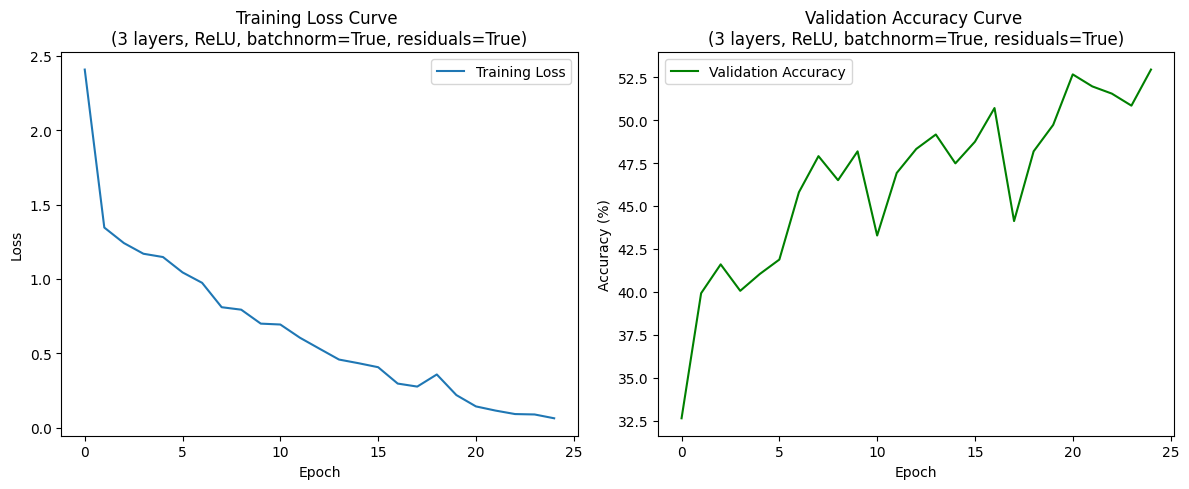

Text appended to AllAccuracies.txt successfully.
Batch normalisation: True; residuals: True; num_layers:3; activation: ReLU
       Test Accuracy of the model on the 10000 test images: 55.03 %
in_channels:3, out_channels:64
16
Batch normalisation: True; residuals: True; num_layers:3; activation: LeakyReLU
Epoch [1/25], Step [50/58], Loss: 2.1116


KeyboardInterrupt: 

In [19]:
def run_model():
    #hyperparameters
    num_epochs = 25
    num_classes = 4
    batch_size = 100
    learning_rate = 0.001

    #this is stupid as hell but my computer died trying to do 7 layers last night and i want to do every permutation
    #which means. this must be automated
    #so now we're going to check what we tested last time we rendered
    models_ive_trained = extract_models_from_file("AllAccuracies.txt")

    bools = [ True, False ]
    num_layers = [3, 4, 5, 6 ] #removed 7 as returns were diminishing on 6 and 7 gets an out of memory error
    activation_funcs = ["ReLU", "LeakyReLU", "GELU"]

    #our dataloader for training dataset
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
    #validation loader
    val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)
    #selecting device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    #printing because my main kernel wants to be stuck on CPU-only pytorch fsr
    print("GPU name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "None")
    for z in range(len(bools)):
        batch_bool = bools[z]
        for m in range(len(bools)):
            residual = bools[m]
            for j in range(len(num_layers)):
                num_layer = num_layers[j]
                for k in range(len(activation_funcs)):
                    activation_func = activation_funcs[k]
                    this_model = f"{batch_bool}{residual}{num_layer}{activation_func}"
                    if this_model in models_ive_trained:
                        print("We've already trained this model, it's getting skipped.")
                    else:
                        model = configConvNet(batch_normal=batch_bool, num_layers=num_layer, activation=activation_func, residuals=residual).to(device)
        
                        # Loss and optimizer
                        criterion = nn.CrossEntropyLoss()
                        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
                        train_losses = []
                        val_accuracies = []
                        
                        # Train the model
                        total_step = len(train_loader)
                        descript = f"Batch normalisation: {bools[z]}; residuals: {bools[m]}; num_layers:{num_layers[j]}; activation: {activation_funcs[k]}";
                        print(descript)
                        
                        for epoch in range(num_epochs):
                            model.train()
                            epoch_loss = 0
                            for i, (images, labels) in enumerate(train_loader):
                                images = images.to(device)
                                labels = labels.to(device)
                                # Forward pass
                                outputs = model(images)
                                loss = criterion(outputs, labels)
        
                                # Backward and optimize
                                optimizer.zero_grad()
                                loss.backward()
                                optimizer.step()
                                epoch_loss += loss.item()                            
                                if (i+1) % 50 == 0:
                                    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, i+1, total_step, loss.item()))
                            
                            avg_loss = epoch_loss / total_step
                            train_losses.append(avg_loss)
                                
                            #now we do validation. exit training mode
                            model.eval()
                            correct = 0                       
                            total = 0
                            with torch.no_grad():
                                for images, labels in val_loader:
                                    images = images.to(device)
                                    labels = labels.to(device)
                                    outputs = model(images)
                                    _, predicted = torch.max(outputs.data, 1)
                                    total += labels.size(0)
                                    correct += (predicted == labels).sum().item()
                            accuracy = 100 * correct / total
                            val_accuracies.append(accuracy)
                            #print(f'Validation Accuracy after epoch {epoch+1}: {accuracy:.2f}%')
                        generate_charts(num_layers=num_layer, activation=activation_func,batch_norm=batch_bool, residuals=residual, train_losses=train_losses, val_accuracies=val_accuracies)                    
                        test_model(model, descript, batch_size, device)
run_model()